# Auto-annotate taps + visualize (Audacity label format)

This notebook uses `scripts/auto_annotate_taps.py` to automatically generate Audacity-style label files (`start\tend\tindex`) from `.wav` recordings, and then visualizes the labels over the waveform.

## Recommended data collection for best accuracy
- Record **one long file per gesture** (e.g., only knuckle taps).
- Tap a **known number of times** (so we can use `expected_count`).
- Keep taps **spaced out** (e.g., >120 ms apart).

Stereo `.wav` is fine: the script converts to mono automatically.


In [1]:
import os
from pathlib import Path

import numpy as np

# Visualization (install if missing): pip install matplotlib
try:
    import matplotlib.pyplot as plt
except Exception as e:
    raise RuntimeError(
        "matplotlib is required for visualization. Install it with: pip install matplotlib\n"
        f"Original import error: {e}"
    )

# Audio preview in notebook
from IPython.display import Audio, display

# Import the repo script as a module
from scripts.auto_annotate_taps import decode_audio_mono, annotate_taps, write_labels


## 1) Choose an input `.wav` and annotation settings

If you know exactly how many taps you performed in the file, set `EXPECTED_COUNT` for best results.


In [2]:
# Input WAV (change this)
WAV_PATH = "audio_file/knuckle.wav"

# Where to write the label file
OUT_DIR = "./labels"

# Accuracy knobs
EXPECTED_COUNT = 10        # set to None if unknown
MIN_GAP_MS = 120           # minimum time between taps
FIXED_DUR_MS = 110         # roughly your labeled duration (ms) per tap
PRE_MS = 10                # include a little before onset

# If EXPECTED_COUNT is None, detection uses a robust threshold on the transient score.
THRESHOLD_Z = 6.0          # higher -> fewer false positives

# Signal-processing knobs (usually leave defaults)
LAG_SAMPLES = 10
SMOOTH_MS = 2.0
ENV_MS = 5.0
ONSET_SEARCH_MS = 30.0
ONSET_FRAC = 0.25

# Segment boundary controls for non-fixed labeling (ignored if FIXED_DUR_MS is set)
BOUNDARY_FRAC = 0.10
MIN_DUR_MS = 20.0
MAX_DUR_MS = 150.0
POST_MS = 0.0

Path(WAV_PATH).exists(), WAV_PATH

(True, 'audio_file/knuckle.wav')

## 2) Run auto-annotation and write the Audacity label file


In [3]:
# Decode audio (mono) using the repo script (ffmpeg is used automatically if available)
x, sr = decode_audio_mono(WAV_PATH, target_sr=None, use_ffmpeg=True)

def ms_to_samples(ms: float) -> int:
    return int(round((ms / 1000.0) * sr))

smooth_win = max(1, ms_to_samples(SMOOTH_MS))
env_win = max(1, ms_to_samples(ENV_MS))
onset_search = max(1, ms_to_samples(ONSET_SEARCH_MS))
min_gap = max(1, ms_to_samples(MIN_GAP_MS))
min_dur = max(1, ms_to_samples(MIN_DUR_MS))
max_dur = max(min_dur, ms_to_samples(MAX_DUR_MS))
fixed_dur = None if FIXED_DUR_MS is None else max(1, ms_to_samples(FIXED_DUR_MS))
pre = max(0, ms_to_samples(PRE_MS))
post = max(0, ms_to_samples(POST_MS))

segments, stats = annotate_taps(
    x,
    sr,
    lag=LAG_SAMPLES,
    smooth_win=smooth_win,
    env_win=env_win,
    onset_search=onset_search,
    onset_frac=ONSET_FRAC,
    pre=pre,
    post=post,
    threshold_z=THRESHOLD_Z,
    min_gap=min_gap,
    boundary_frac=BOUNDARY_FRAC,
    min_dur=min_dur,
    max_dur=max_dur,
    fixed_dur=fixed_dur,
    expected_count=EXPECTED_COUNT,
)

wav_base = Path(WAV_PATH).stem
out_path = str(Path(OUT_DIR) / f"{wav_base}.txt")
write_labels(out_path, segments, sr)

print(f"Wrote labels: {out_path}")
print(f"Detected segments: {len(segments)}")
print(f"Sample rate: {sr} Hz, duration: {stats['seconds']:.3f} s")
print(f"Threshold used (score domain): {stats['threshold']:.6g}")
if EXPECTED_COUNT is not None and len(segments) != EXPECTED_COUNT:
    print(f"WARNING: expected {EXPECTED_COUNT} taps, but detected {len(segments)}")


Wrote labels: labels/knuckle.txt
Detected segments: 10
Sample rate: 48000 Hz, duration: 4.656 s
Threshold used (score domain): 0.00396698


## 3) Visualize the waveform + annotations


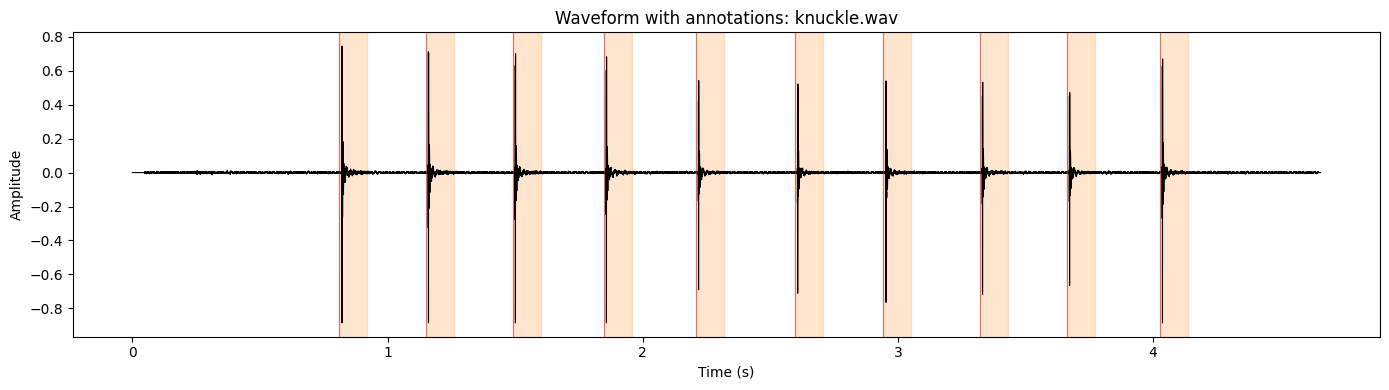

In [4]:
labels = np.loadtxt(out_path, delimiter="\t")
if labels.ndim == 1:
    labels = labels.reshape(1, -1)

t = np.arange(len(x), dtype=np.float32) / float(sr)

plt.figure(figsize=(14, 4))
plt.plot(t, x, lw=0.8, color="black")
plt.title(f"Waveform with annotations: {Path(WAV_PATH).name}")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")

for start_s, end_s, idx in labels:
    plt.axvspan(start_s, end_s, alpha=0.20, color="tab:orange")
    plt.axvline(start_s, color="tab:red", lw=0.8, alpha=0.6)

plt.tight_layout()
plt.show()


## 4) Zoom in on a few taps


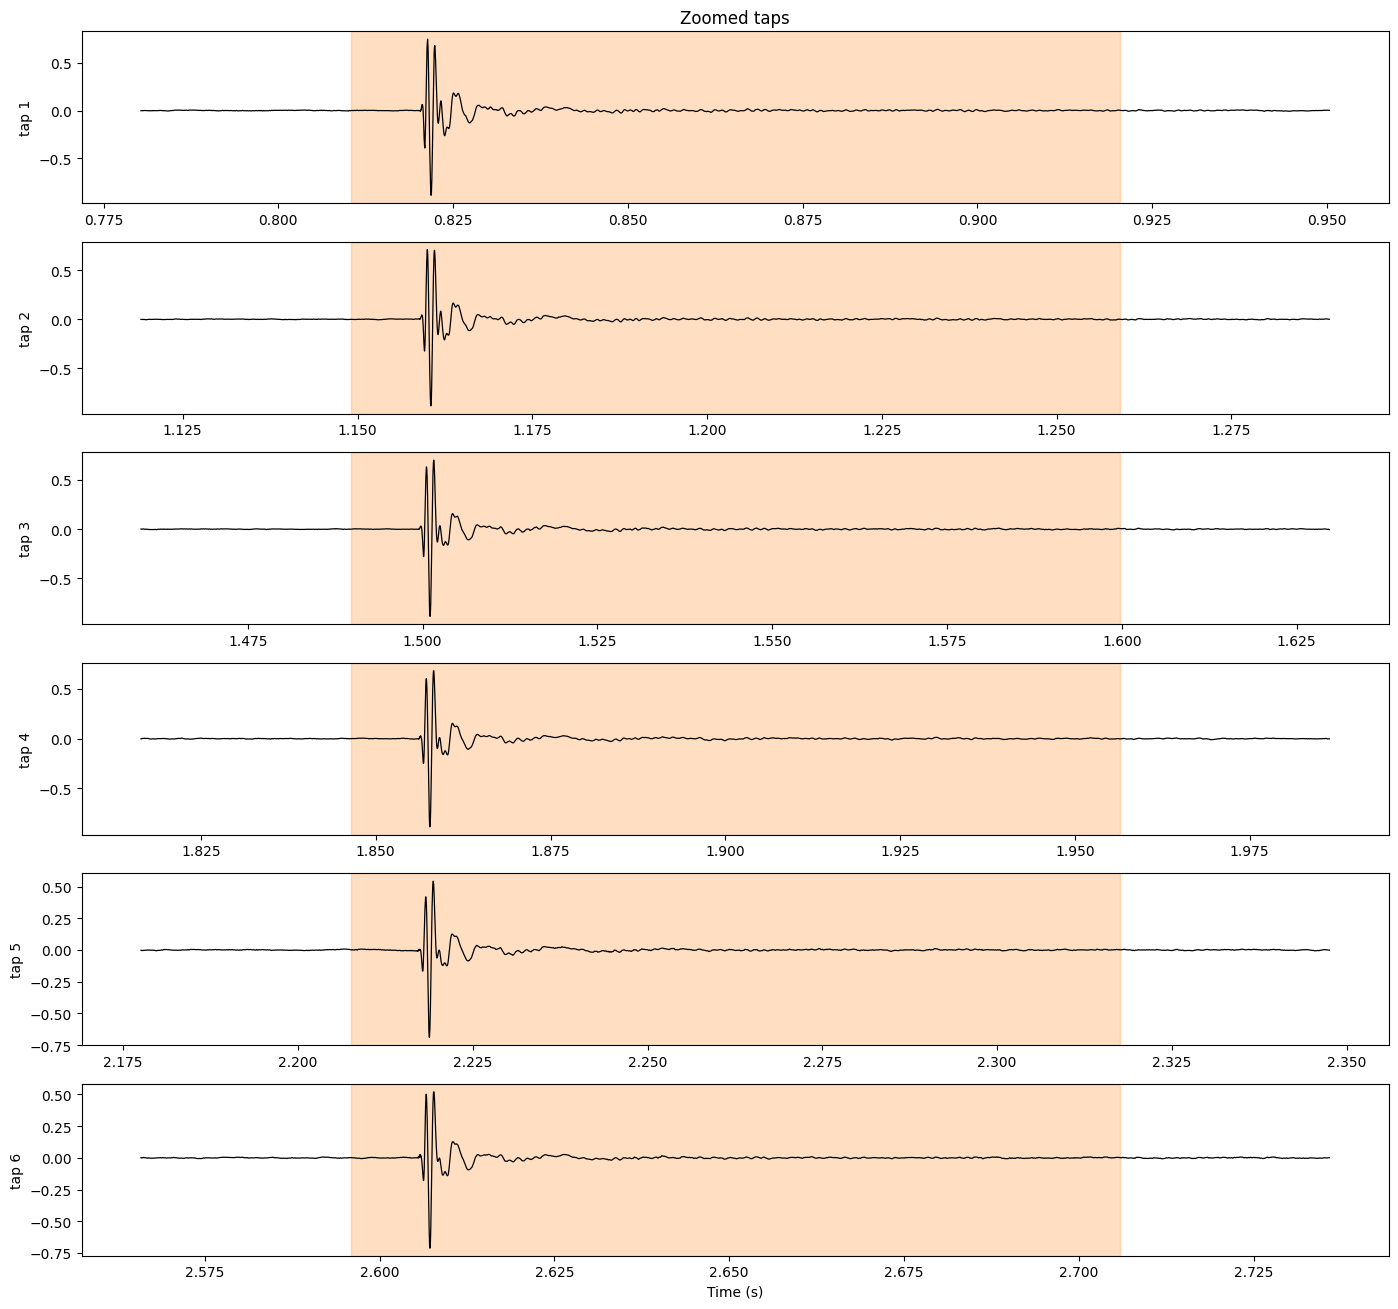

In [5]:
N_SHOW = min(6, labels.shape[0])
PAD_MS = 30.0
pad = int(round((PAD_MS / 1000.0) * sr))

plt.figure(figsize=(14, 2.2 * N_SHOW))
for i in range(N_SHOW):
    start_s, end_s, idx = labels[i]
    start = int(round(start_s * sr))
    end = int(round(end_s * sr))
    lo = max(0, start - pad)
    hi = min(len(x), end + pad)

    tt = np.arange(lo, hi) / float(sr)
    xx = x[lo:hi]

    ax = plt.subplot(N_SHOW, 1, i + 1)
    ax.plot(tt, xx, lw=0.9, color="black")
    ax.axvspan(start_s, end_s, alpha=0.25, color="tab:orange")
    ax.set_ylabel(f"tap {int(idx)}")
    if i == 0:
        ax.set_title("Zoomed taps")
    if i == N_SHOW - 1:
        ax.set_xlabel("Time (s)")

plt.tight_layout()
plt.show()


## 5) Listen


In [ ]:
display(Audio(x, rate=sr))
